In [1]:
import time, os, pdb, pickle, argparse, shutil, yaml, torch, math, time, pdb, datetime, pickle
import utils #file
from solver_encoder import Solver 
from data_loader import pathSpecDataset
from torch.utils.data import DataLoader
from torch.backends import cudnn
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
import torch.nn.functional as F

In [2]:
# tailor config, define other 
cudnn.benchmark = True
autovc_model_dir = '/homes/bdoc3/my_data/autovc_data/vte-autovc/model_saves/FirstVte_autovcTest'
config = pickle.load(open(autovc_model_dir +'/config.pkl','rb'))
autovc_ckpt_path = autovc_model_dir +'/ckpts/ckpt_100000.pth.tar'
config.autovc_ckpt = autovc_ckpt_path
# additional config attrs
config.vte_ckpt = '/homes/bdoc3/phonDet/results/newStandardAutovcSpmelParamsUnnormLatent64Out256/best_epoch_checkpoint.pth.tar'
config.device = torch.device(f'cuda:{config.which_cuda}' if torch.cuda.is_available() else 'cpu')
with open(config.spmel_dir +'/spmel_params.yaml') as File:
    spmel_params = yaml.load(File, Loader=yaml.FullLoader)
config

Namespace(adam_init=0.0001, autovc_ckpt='/homes/bdoc3/my_data/autovc_data/vte-autovc/model_saves/FirstVte_autovcTest/ckpts/ckpt_100000.pth.tar', batch_size=2, chunk_num=6, chunk_seconds=0.5, ckpt_freq=10000, config_file='', data_dir='/homes/bdoc3/my_data/autovc_data/vte-autovc', device=device(type='cuda', index=0), dim_emb=256, dim_neck=32, dim_pre=512, emb_ckpt='/homes/bdoc3/phonDet/results/newStandardAutovcSpmelParamsUnnormLatent64Out256/best_epoch_checkpoint.pth.tar', file_name='FirstVte_autovcTest', freq=32, lambda_cd=1, len_crop=192, load_ckpts='', log_step=10, num_iters=100000, one_hot=False, prnt_loss_weight=1.0, psnt_loss_weight=1.0, shape_adapt=True, spec_freq=10000, spmel_dir='/homes/bdoc3/my_data/phonDet/spmel_autovc_params_unnormalized', train_size=21, vte_ckpt='/homes/bdoc3/phonDet/results/newStandardAutovcSpmelParamsUnnormLatent64Out256/best_epoch_checkpoint.pth.tar', which_cuda=0)

In [3]:
# import path to use autovc_model_dir's .py
import sys
sys.path.insert(1, autovc_model_dir) # usually the cwd is priority, so index 1 is good enough for our purposes here
print(sys.path)
from this_model_vc import Generator

# setup dataloader, models
vocalSet = pathSpecDataset(config, spmel_params)
vocalSet_loader = DataLoader(vocalSet, batch_size=config.batch_size, shuffle=True, drop_last=False)
G = utils.setup_gen(config, Generator)
vte = utils.setup_vte(config, spmel_params)

['/homes/bdoc3/vte-autovc', '/homes/bdoc3/my_data/autovc_data/vte-autovc/model_saves/FirstVte_autovcTest', '', '/import/linux/python/3.7.7/lib/python3.7/site-packages', '/import/linux/python/3.7.7/lib/python37.zip', '/import/linux/python/3.7.7/lib/python3.7', '/import/linux/python/3.7.7/lib/python3.7/lib-dynload', '/homes/bdoc3/.local/lib/python3.7/site-packages', '/homes/bdoc3/.local/lib/python3.7/site-packages/IPython/extensions', '/homes/bdoc3/.ipython']


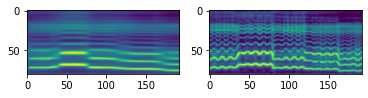

In [4]:
# get data
data_iter = iter(vocalSet_loader)
x_real, style_idx, singer_idx = next(data_iter)
x_real = x_real.to(config.device)
x_real_chunked = x_real.view(x_real.shape[0]*config.chunk_num, x_real.shape[1]//config.chunk_num, -1)
pred_style_idx, all_tensors = vte(x_real_chunked)
emb_org = all_tensors[-1]
# x_identic_psnt consists of the original mel + the residual definiton added ontop
x_identic, x_identic_psnt, code_real, saved_enc_outs, saved_dec_outs = G(x_real, emb_org, emb_org)
batch_id = 0
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.rot90(x_identic.squeeze(1)[batch_id].cpu().detach().numpy()))
plt.subplot(1,2,2)
plt.imshow(np.rot90(x_real[batch_id].cpu().detach().numpy()))

In [5]:
print(len(saved_enc_outs)) # should contain output tensors for:
enc_outs = ['mel_cat_emb','conv1','conv2','conv3','lstm','resampled']
print(len(saved_dec_outs)) # should contain output tensors for:
dec_outs = ['input','lstm1','conv1','conv2','conv3','lstm2','dense']

5
7


In [6]:
if not os.path.exists(autovc_model_dir + '/tensor_views'):
    os.makedirs(autovc_model_dir + '/tensor_views')

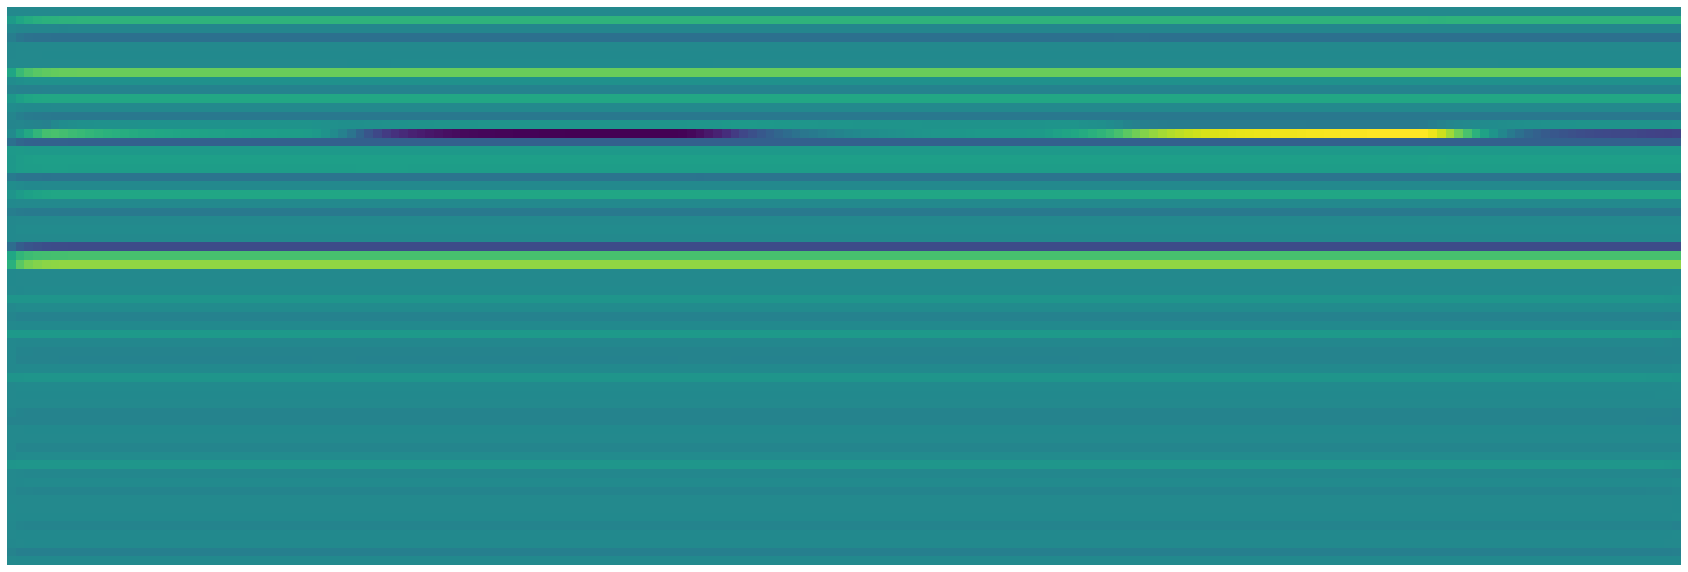

In [9]:
plt.figure(figsize=(30,30))
example = saved_enc_outs[4][0]
if len(example.shape) == 3:
    for i, tensor in enumerate(example):
        if i == 64:
            break
        tensor_arr = tensor.cpu().detach().numpy()
        plt.subplot(8, 8, i + 1)
        plt.imshow(tensor_arr)
        plt.xticks()
        plt.axis("off")
else:
    tensor_arr = example.cpu().detach().numpy()
    plt.imshow(tensor_arr)
    plt.axis("off")

Saving layer saved_enc_outs0 feature maps...
Saving layer saved_enc_outs1 feature maps...
Saving layer saved_enc_outs2 feature maps...
Saving layer saved_enc_outs3 feature maps...
Saving layer saved_enc_outs4 feature maps...
Saving layer saved_enc_outs5 feature maps...
Saving layer saved_enc_outs6 feature maps...
Saving layer saved_enc_outs0 feature maps...
Saving layer saved_enc_outs1 feature maps...
Saving layer saved_enc_outs2 feature maps...
Saving layer saved_enc_outs3 feature maps...
Saving layer saved_enc_outs4 feature maps...
Saving layer saved_enc_outs5 feature maps...
Saving layer saved_enc_outs6 feature maps...


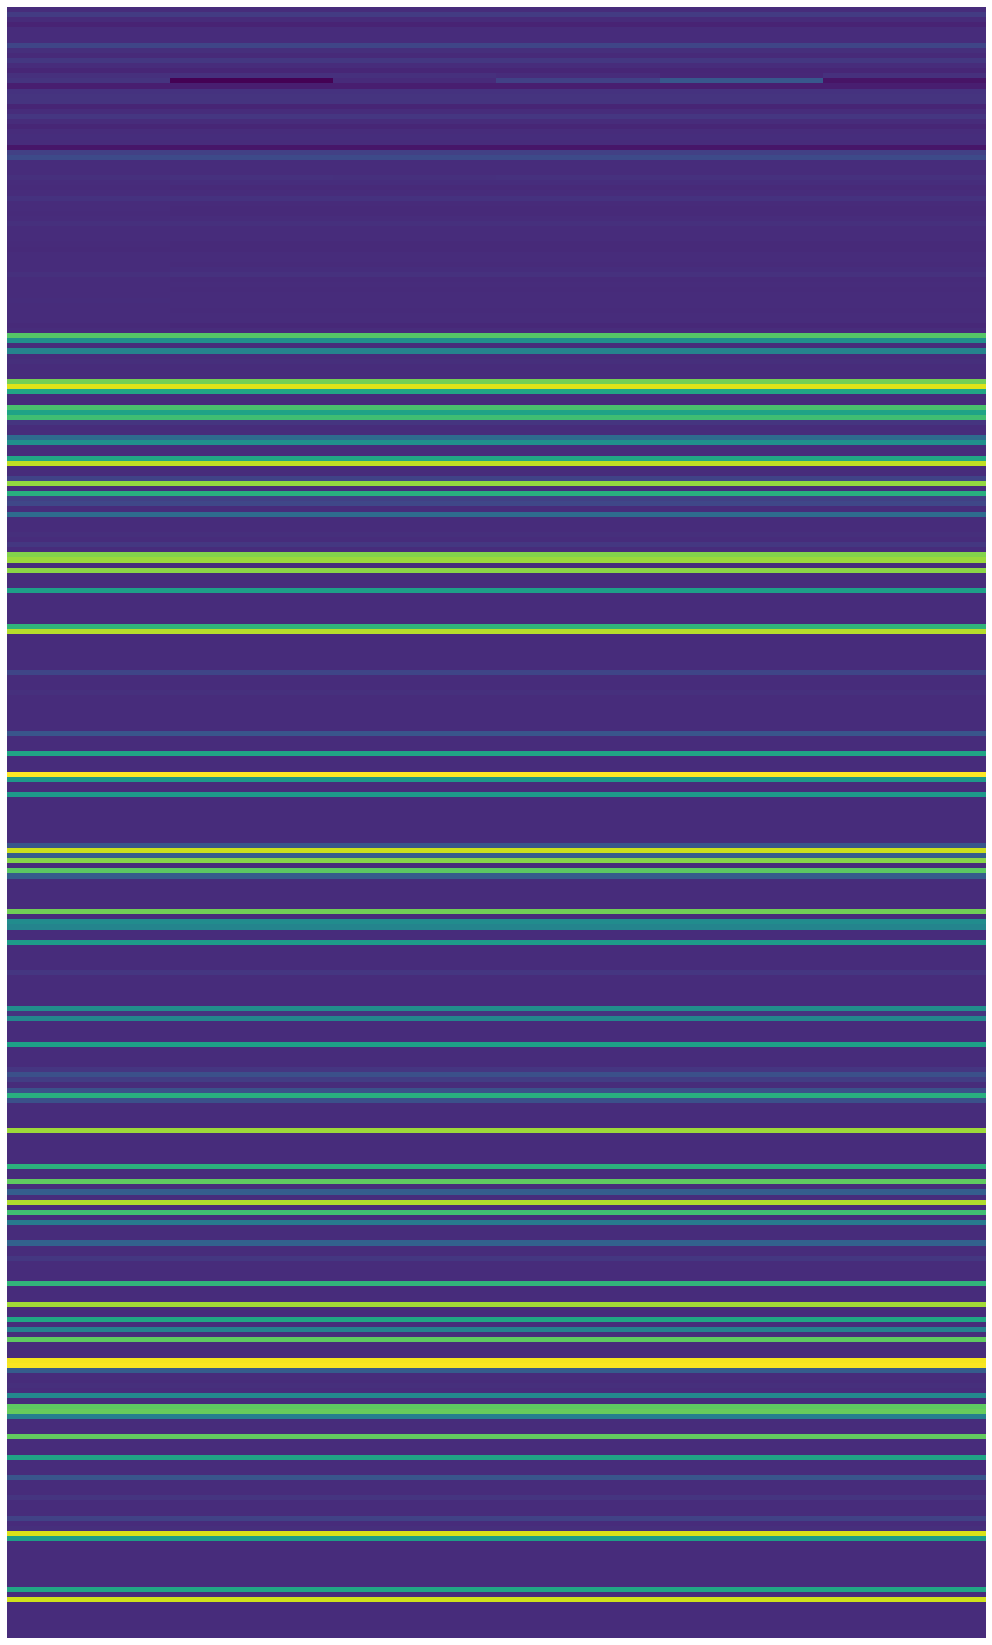

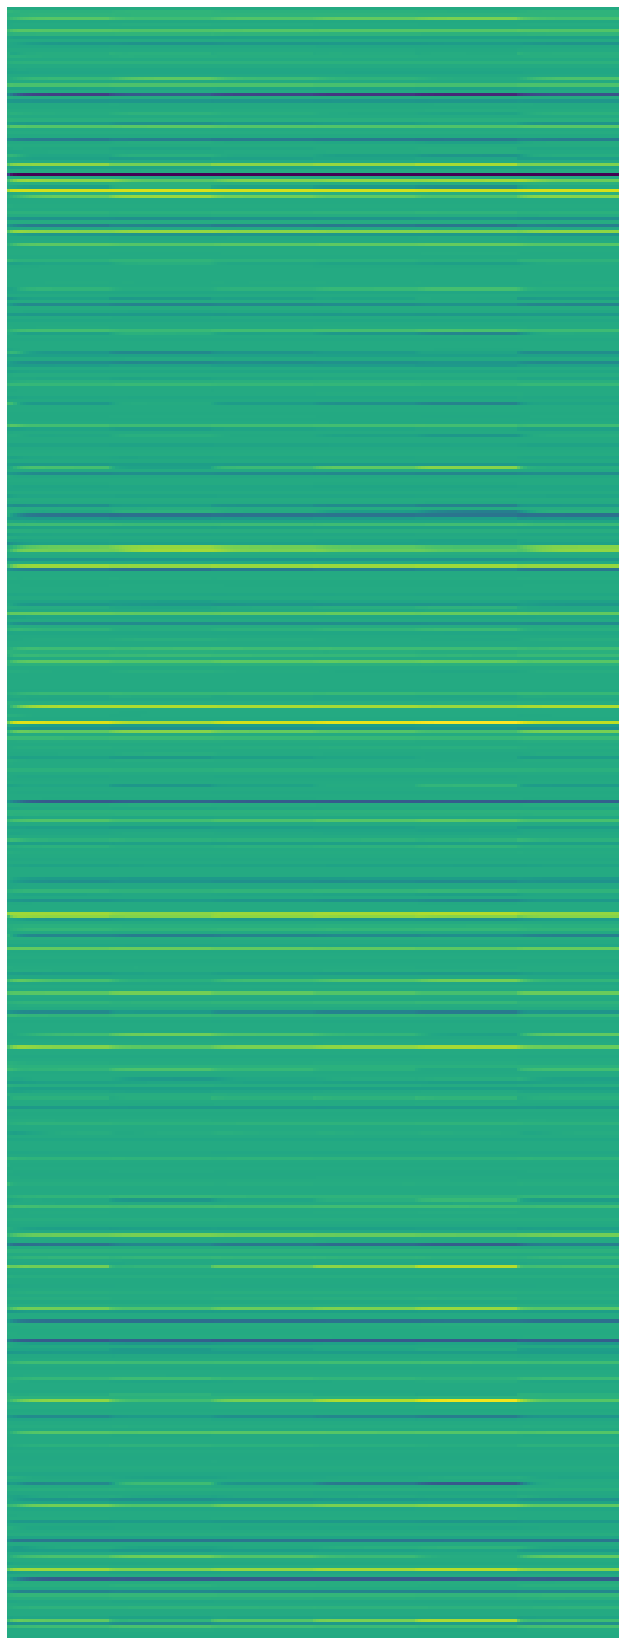

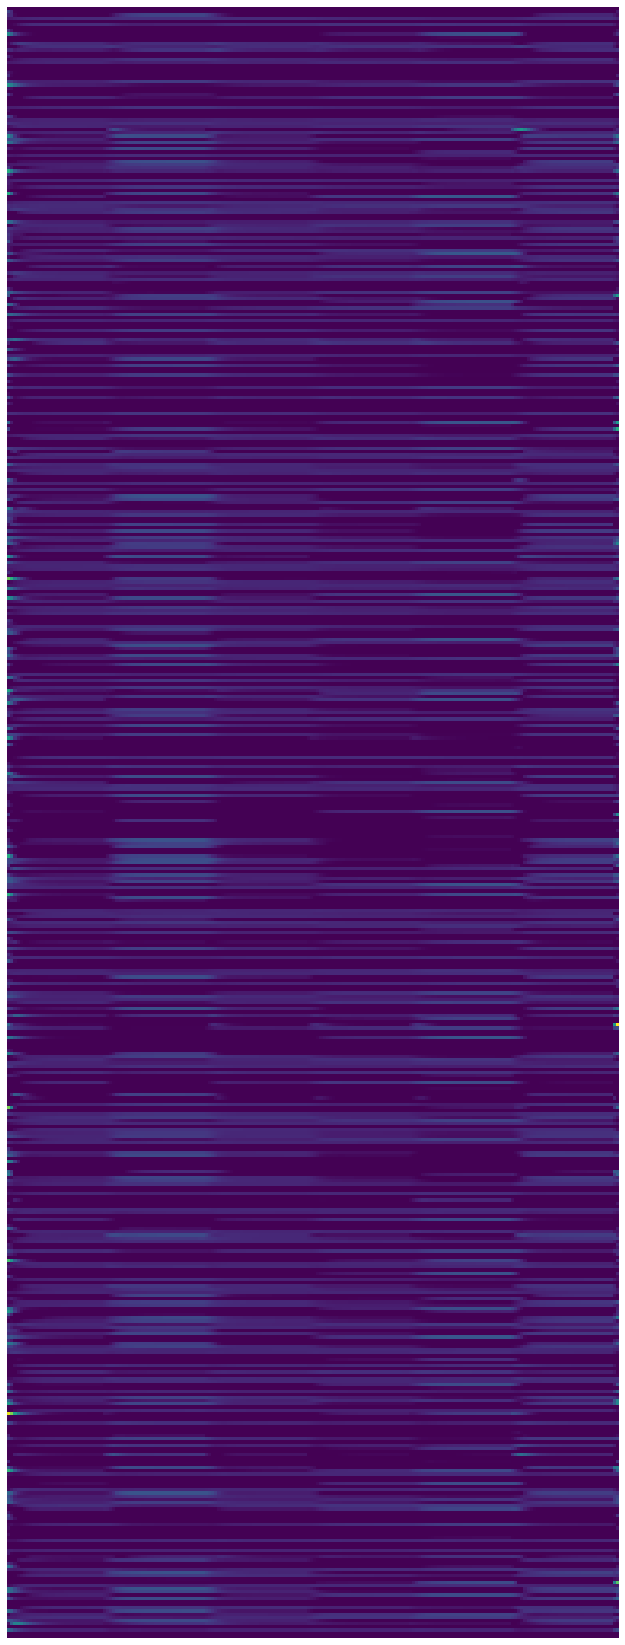

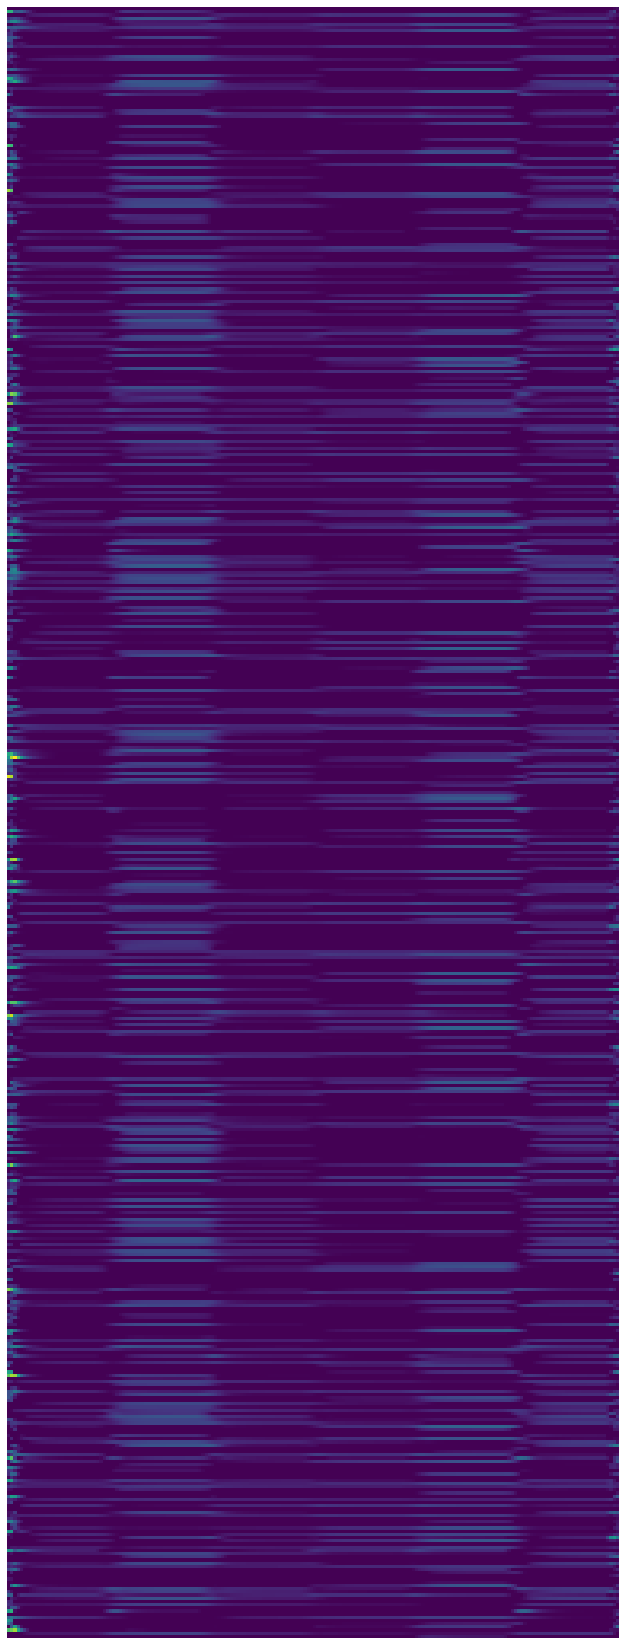

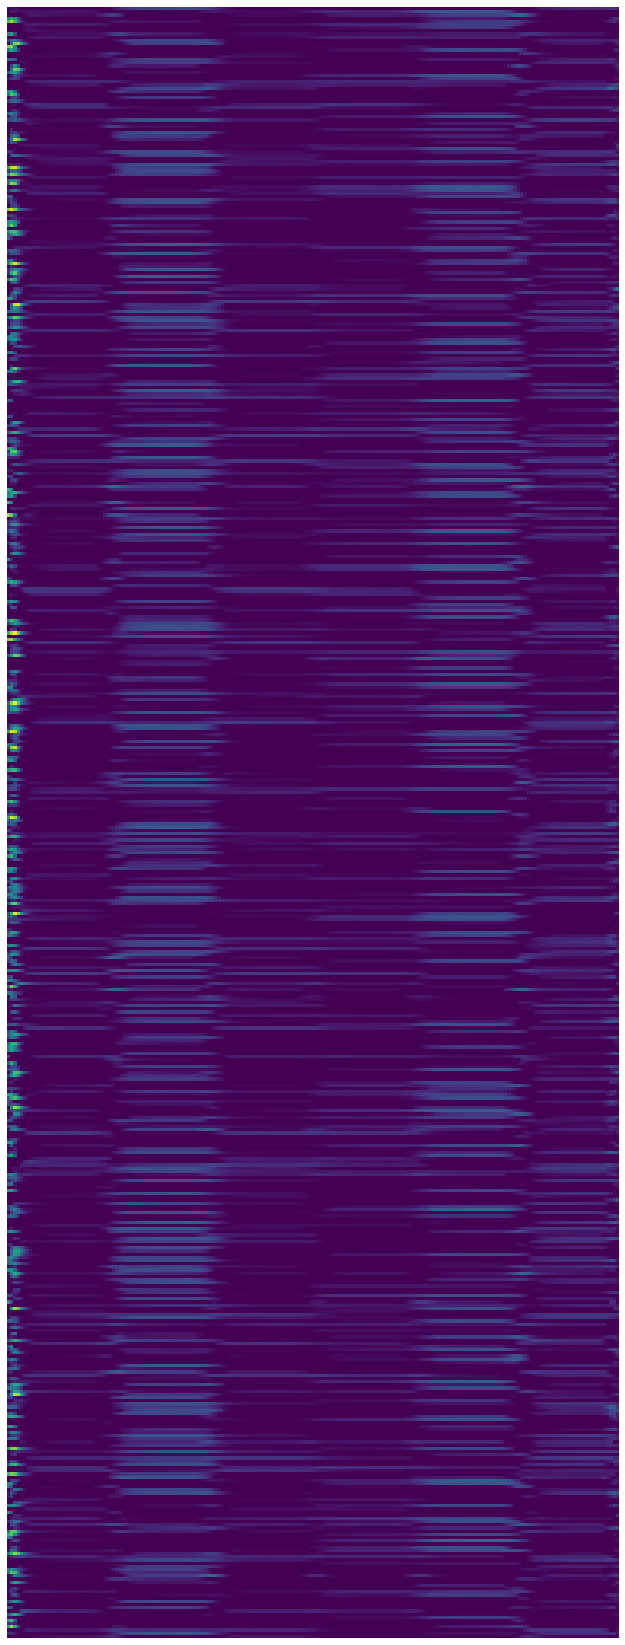

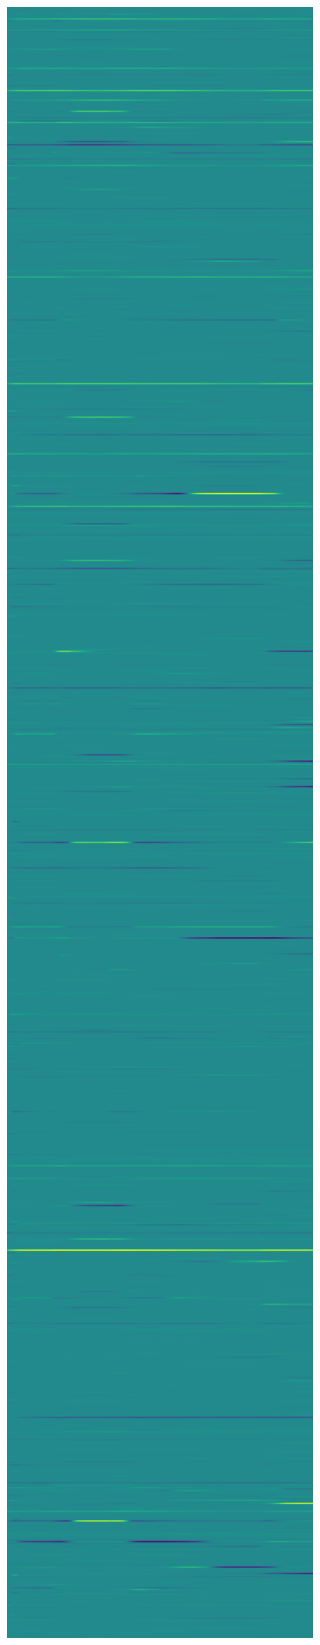

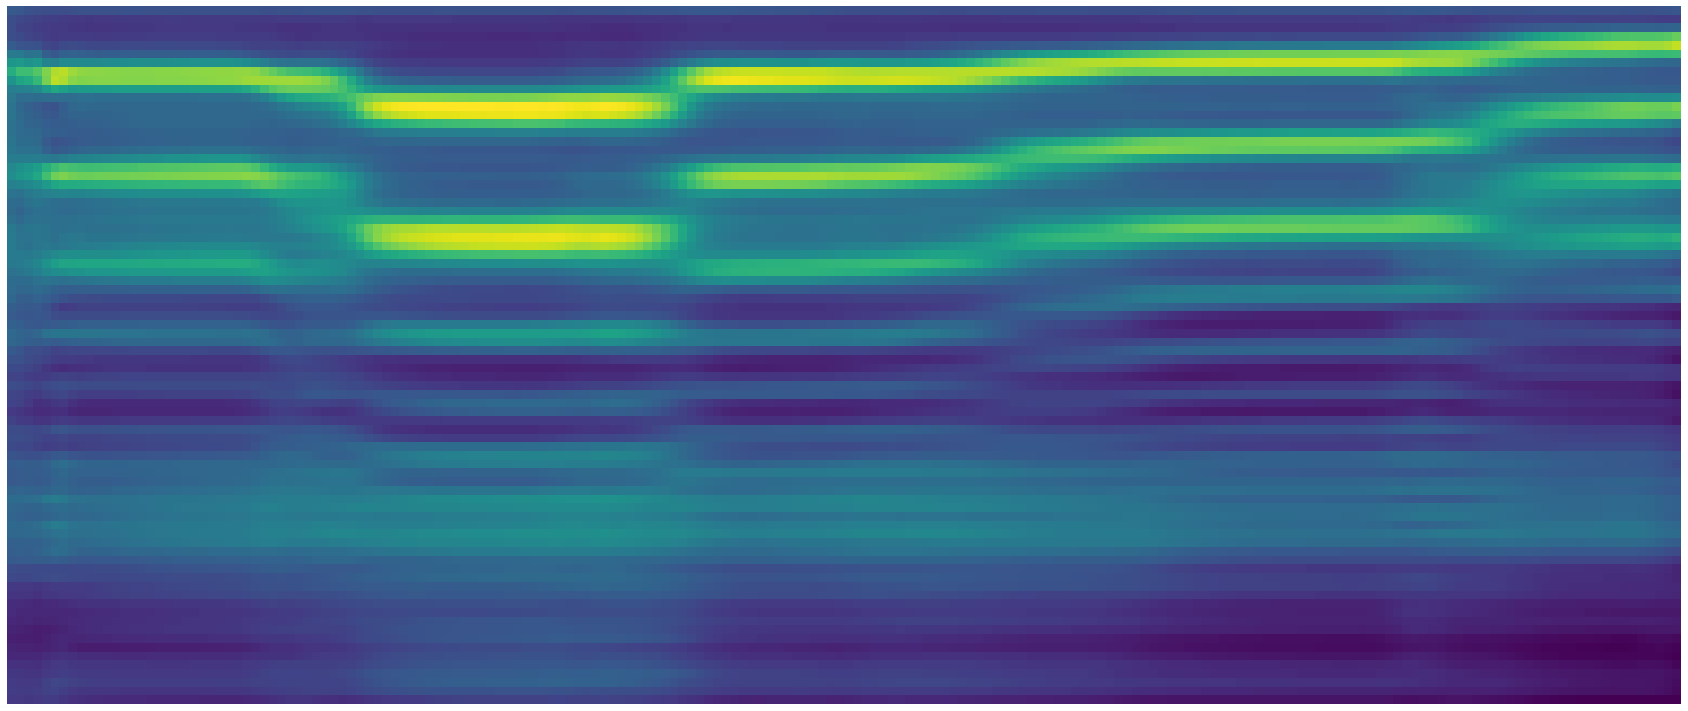

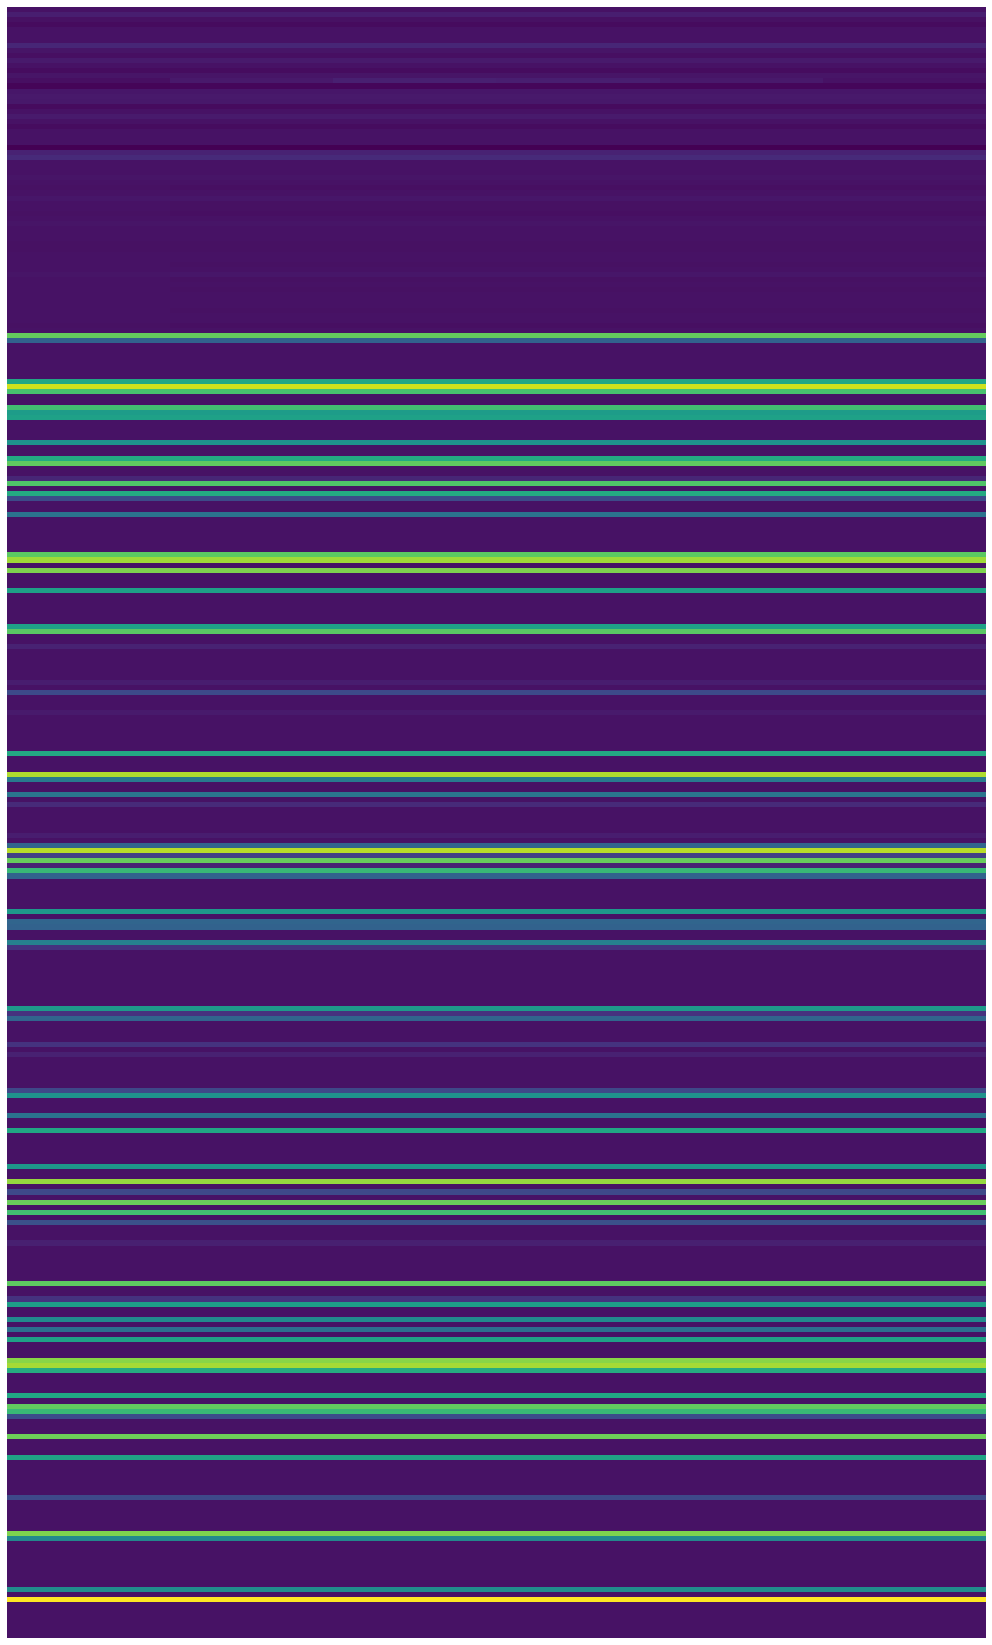

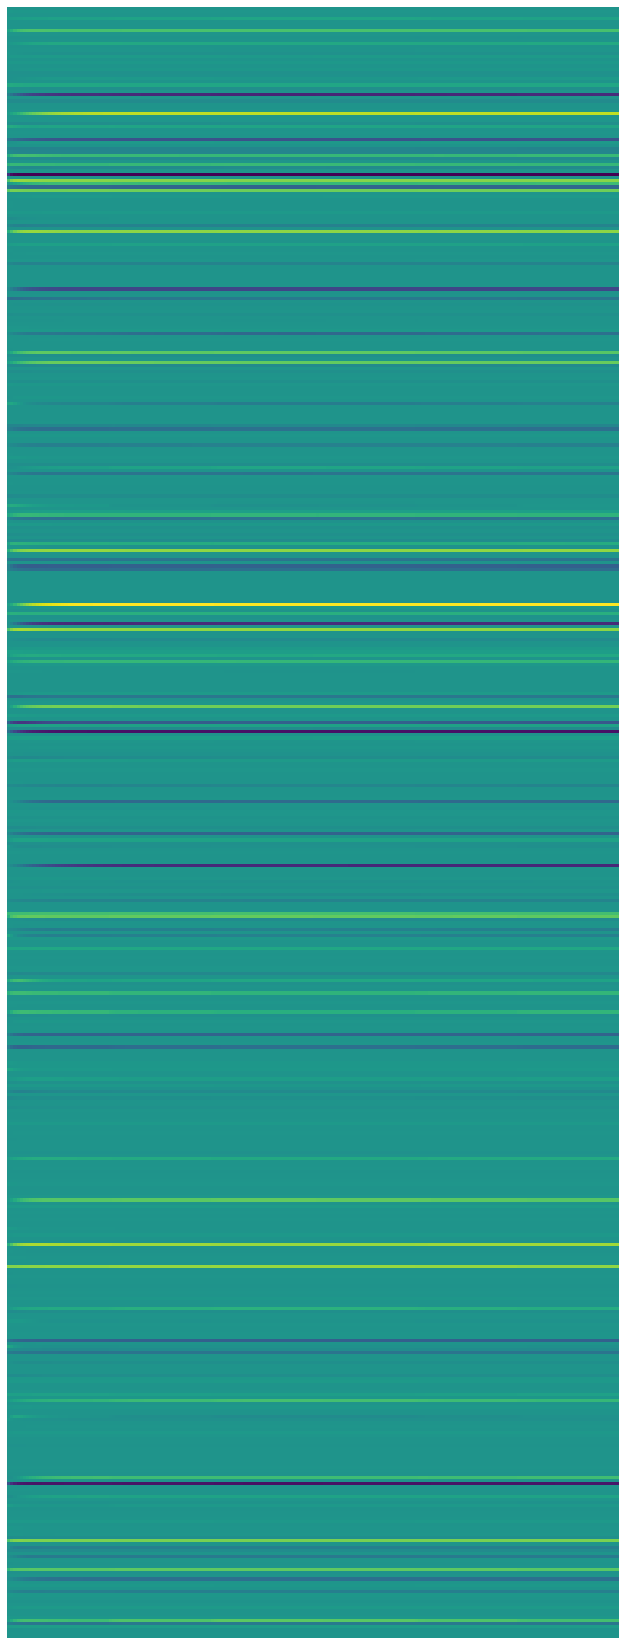

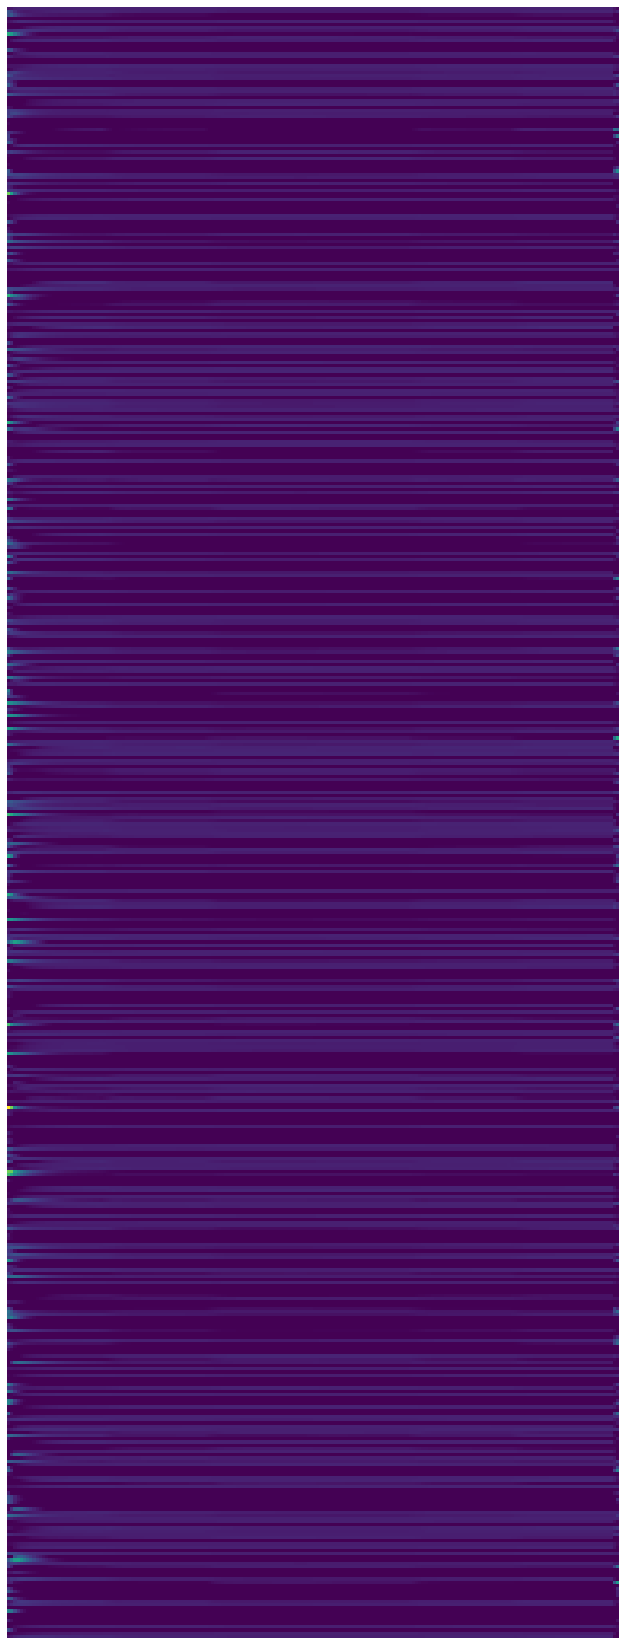

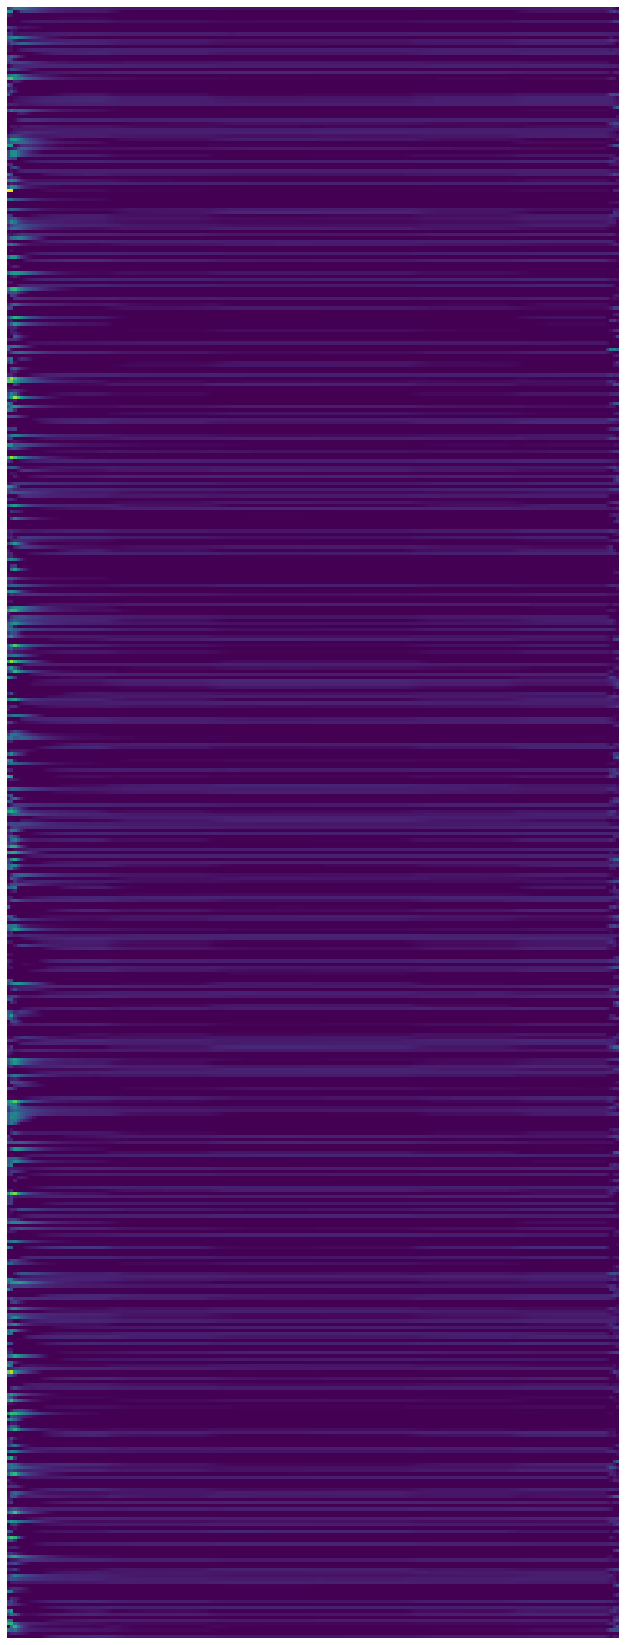

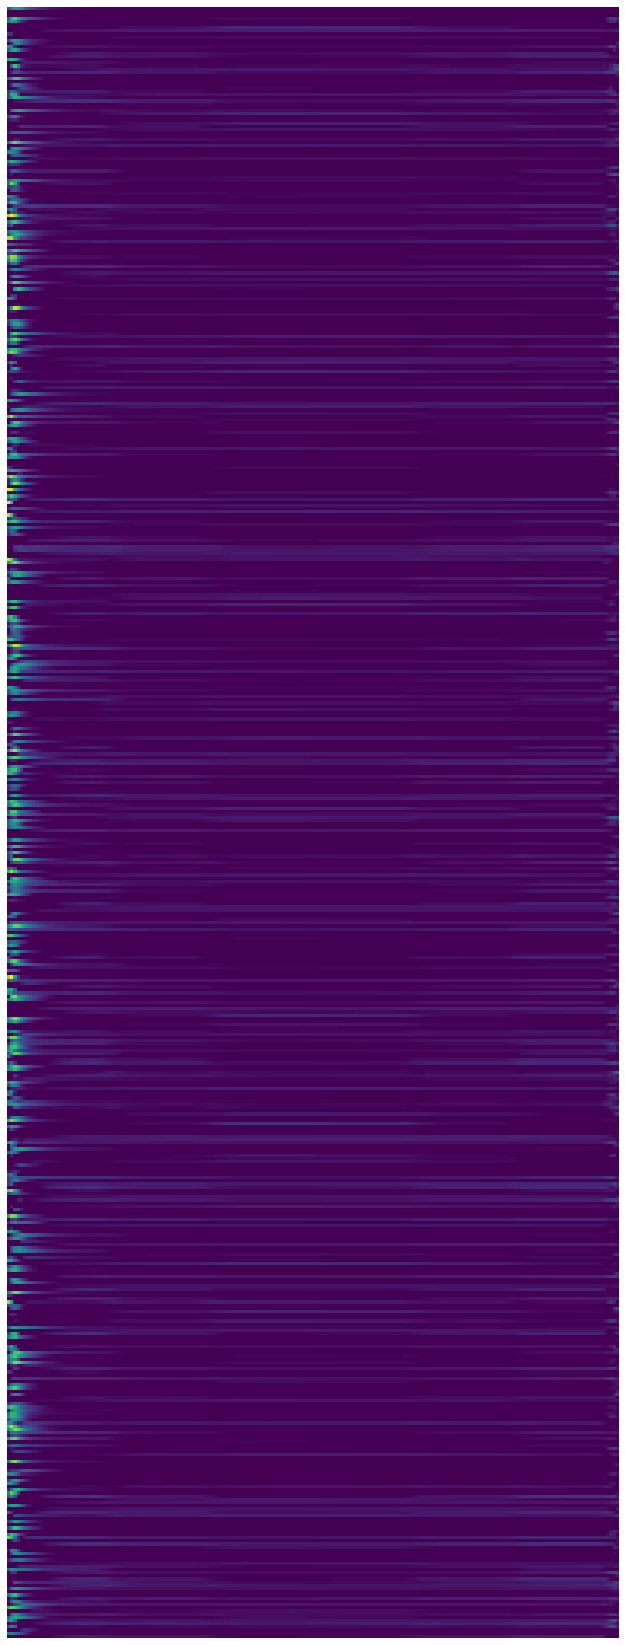

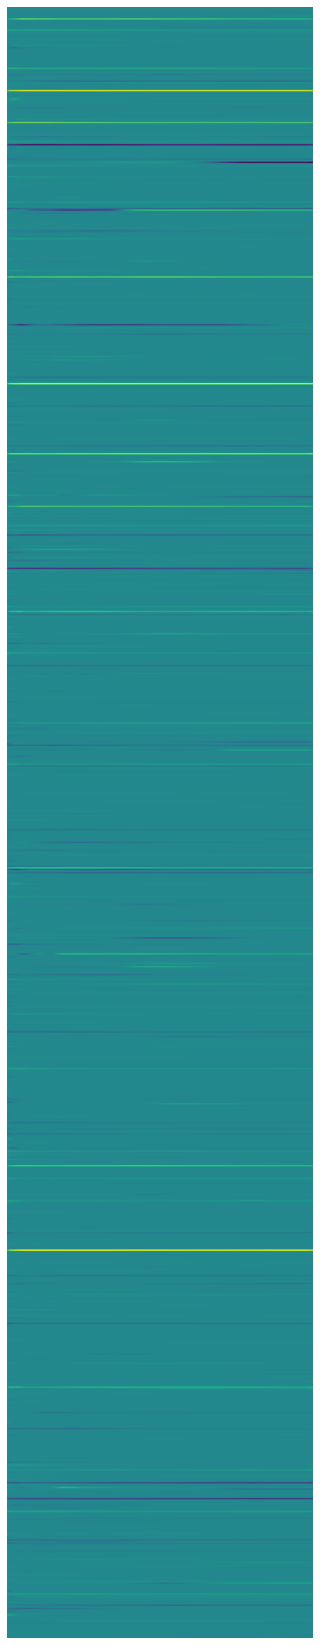

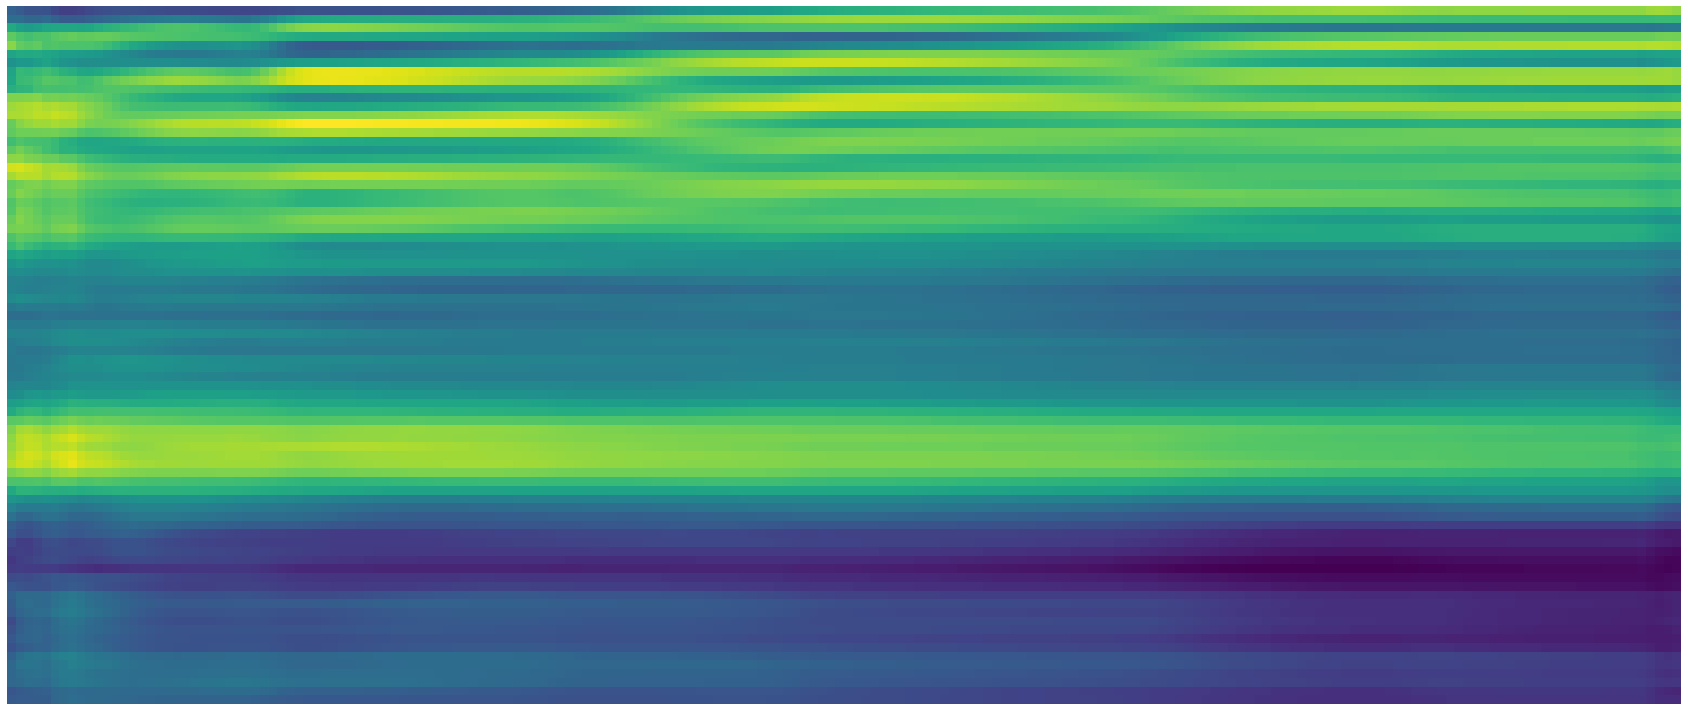

In [12]:
for batch_id in range(2):
    for layer in range(len(saved_dec_outs)):
        plt.figure(figsize=(30,30))
        example = saved_dec_outs[layer][batch_id]
        if len(example.shape) == 3:
            for i, tensor in enumerate(example):
                if i == 64:
                    break
                tensor_arr = tensor.cpu().detach().numpy()
                plt.subplot(8, 8, i + 1)
                plt.imshow(tensor_arr)
                plt.axis("off")
        else:
            tensor_arr = example.cpu().detach().numpy()
            plt.imshow(tensor_arr)
            plt.axis("off")
        print(f"Saving layer saved_enc_outs{layer} feature maps...")
        plt.savefig(autovc_model_dir + f"/tensor_views/SavedDecOuts_Batch{batch_id}_Layer{layer}_{dec_outs[layer]}.png")

Saving layer saved_enc_outs0 feature maps...
Saving layer saved_enc_outs1 feature maps...
Saving layer saved_enc_outs2 feature maps...
Saving layer saved_enc_outs3 feature maps...
Saving layer saved_enc_outs4 feature maps...
Saving layer saved_enc_outs0 feature maps...
Saving layer saved_enc_outs1 feature maps...
Saving layer saved_enc_outs2 feature maps...
Saving layer saved_enc_outs3 feature maps...
Saving layer saved_enc_outs4 feature maps...


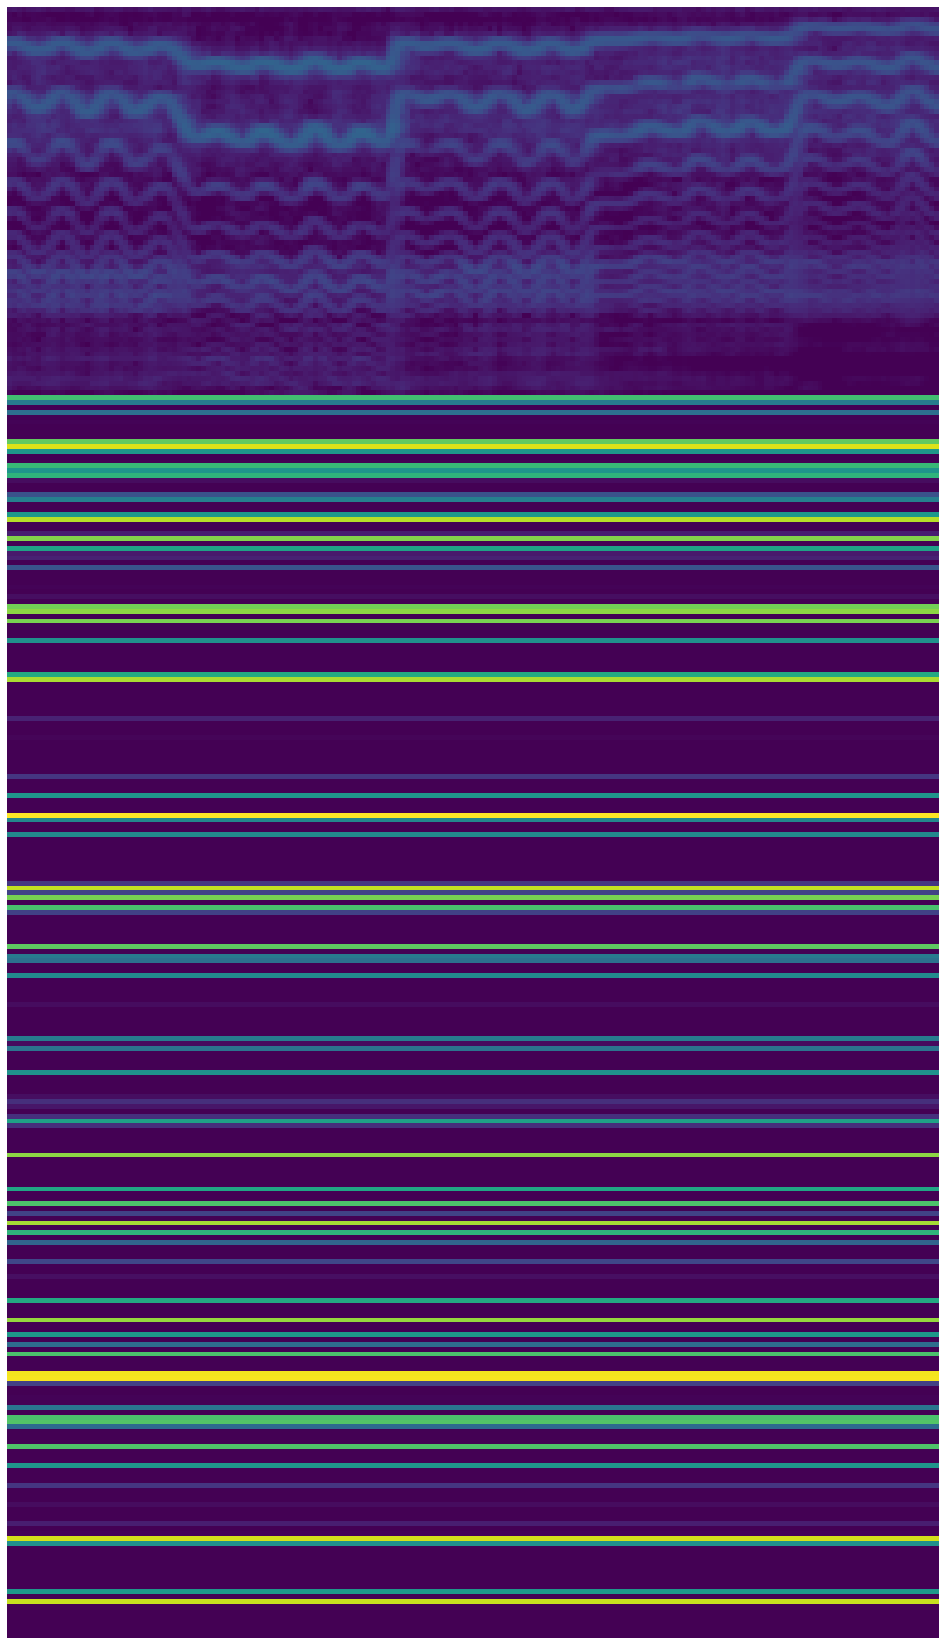

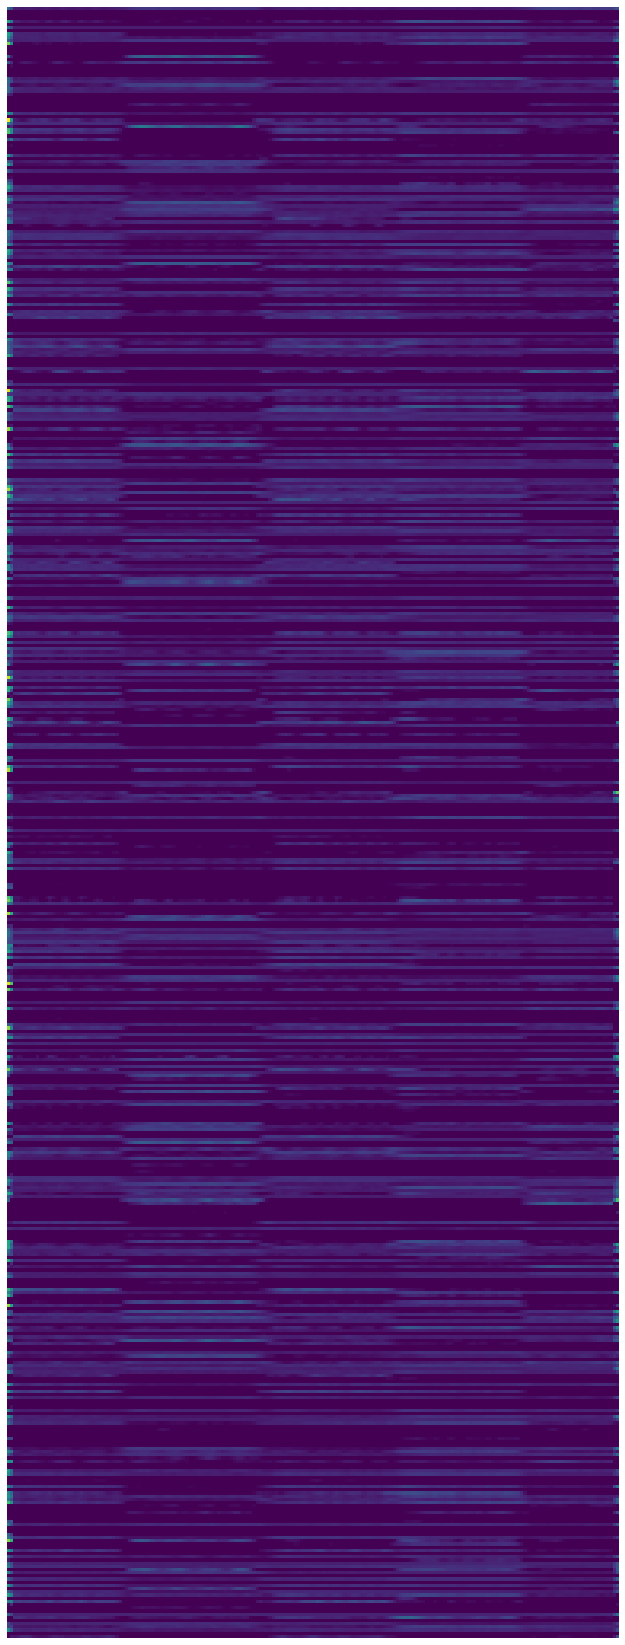

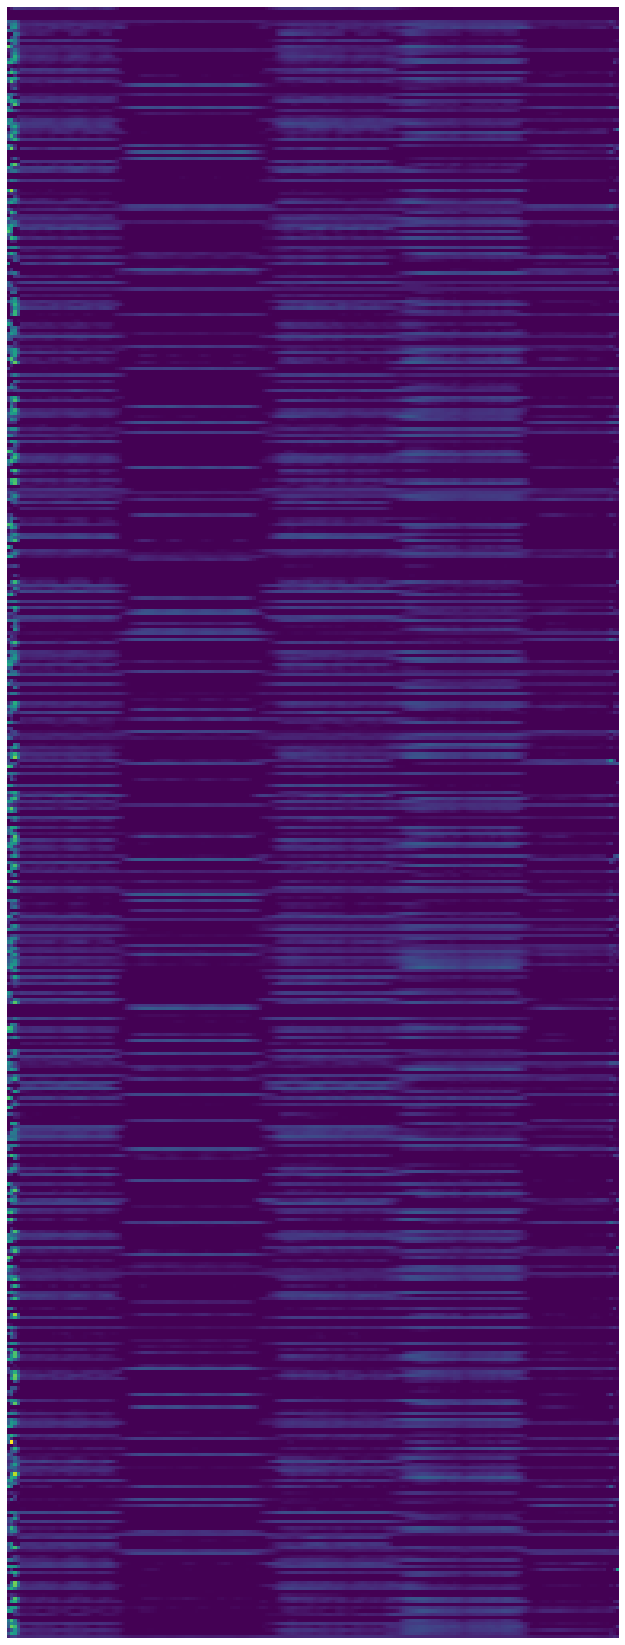

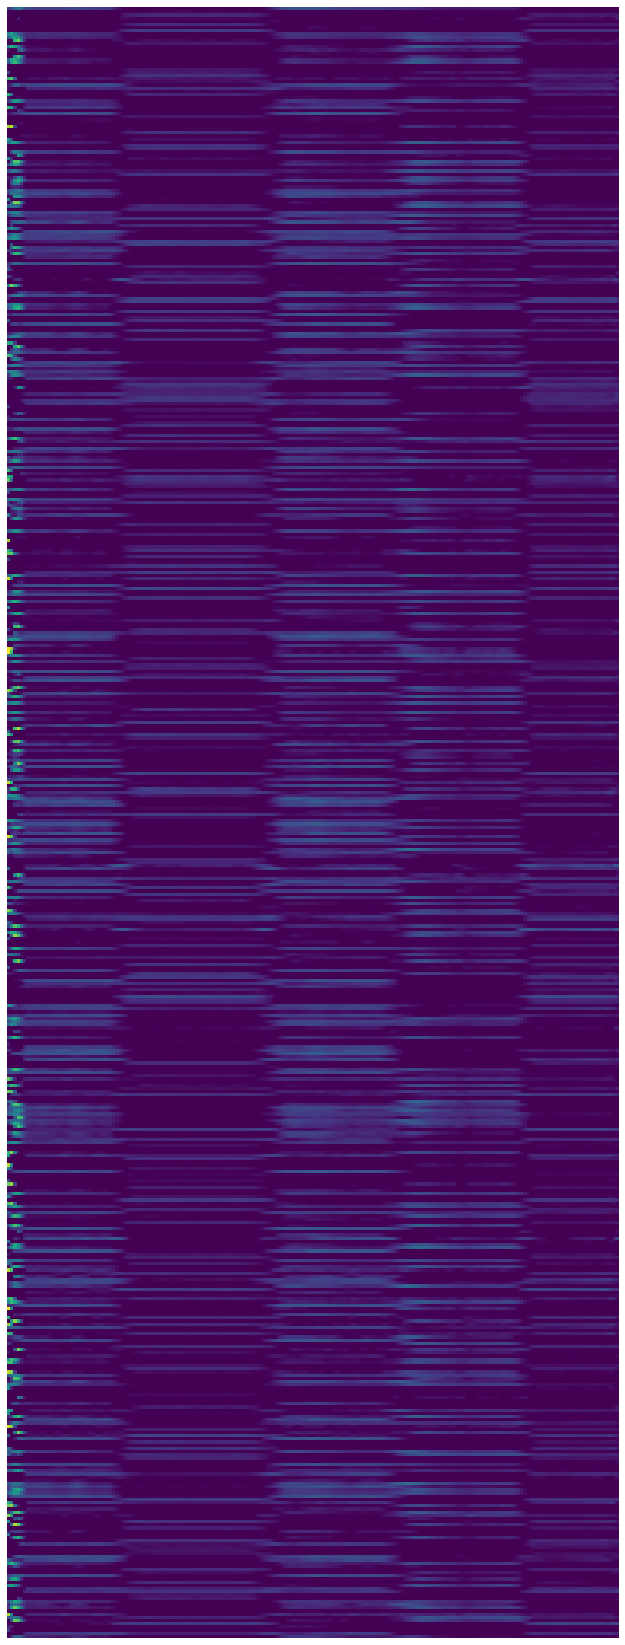

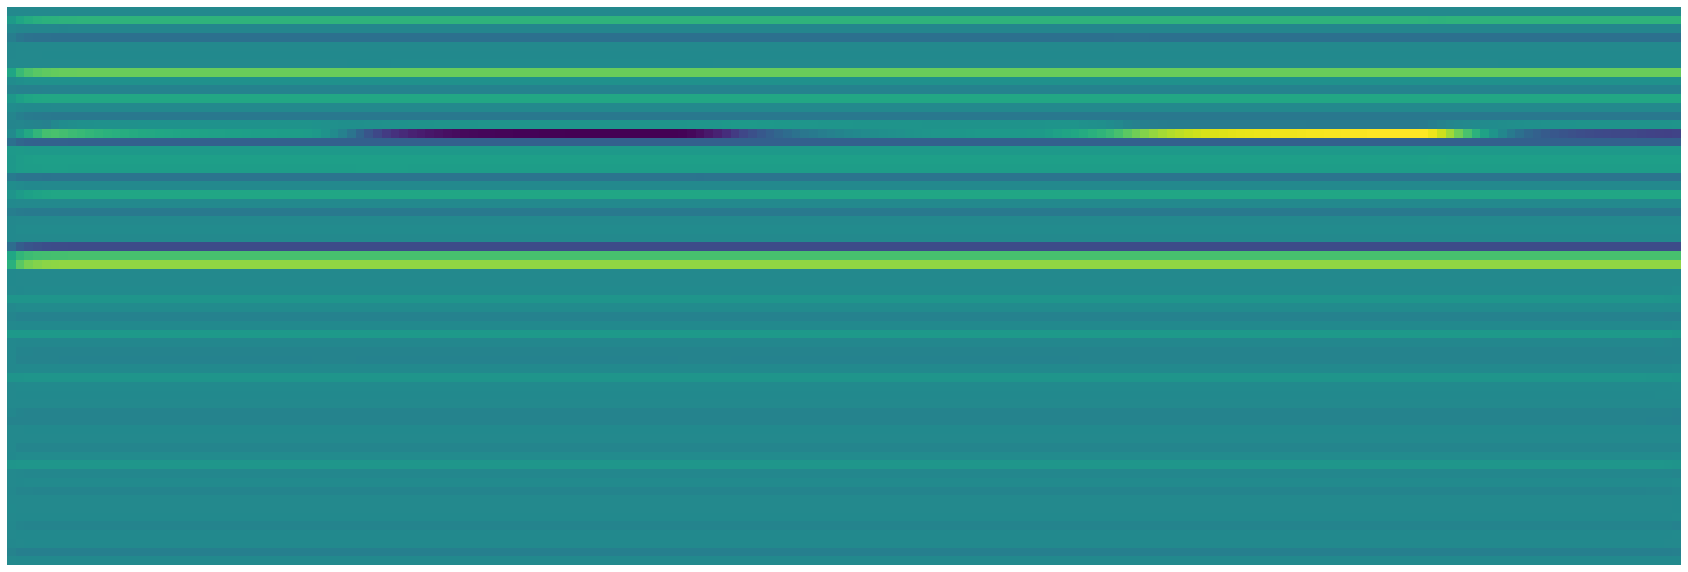

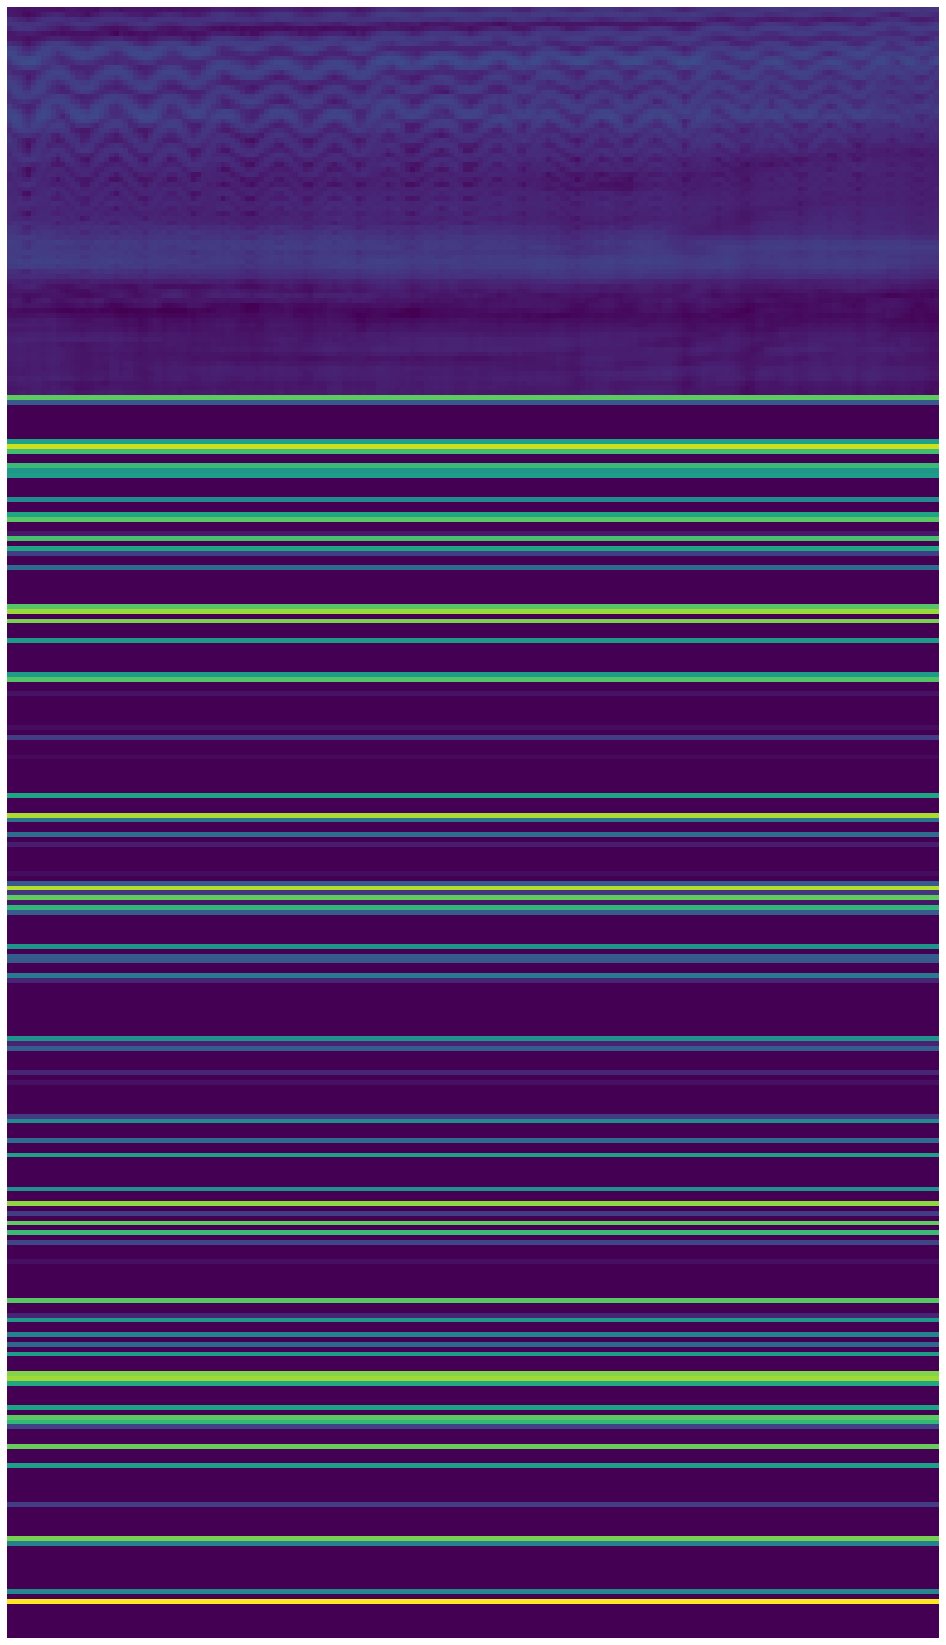

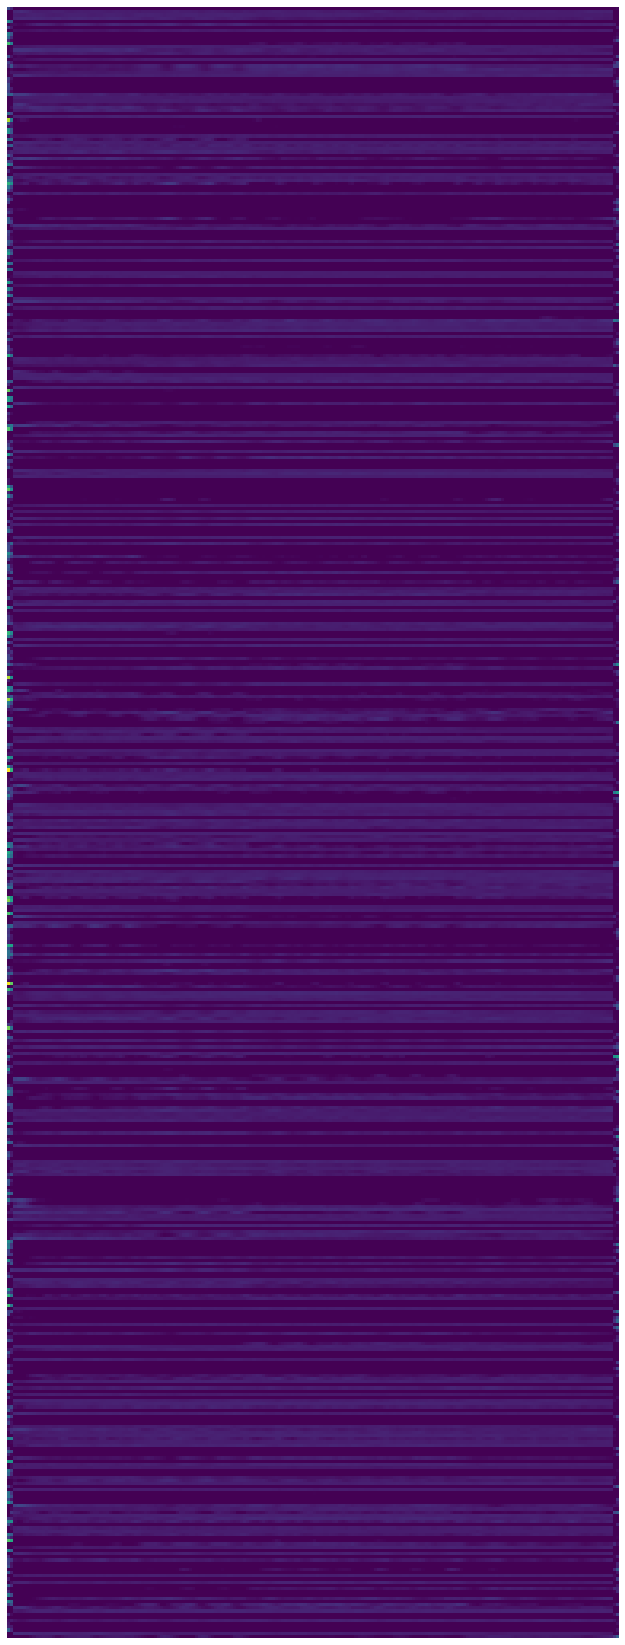

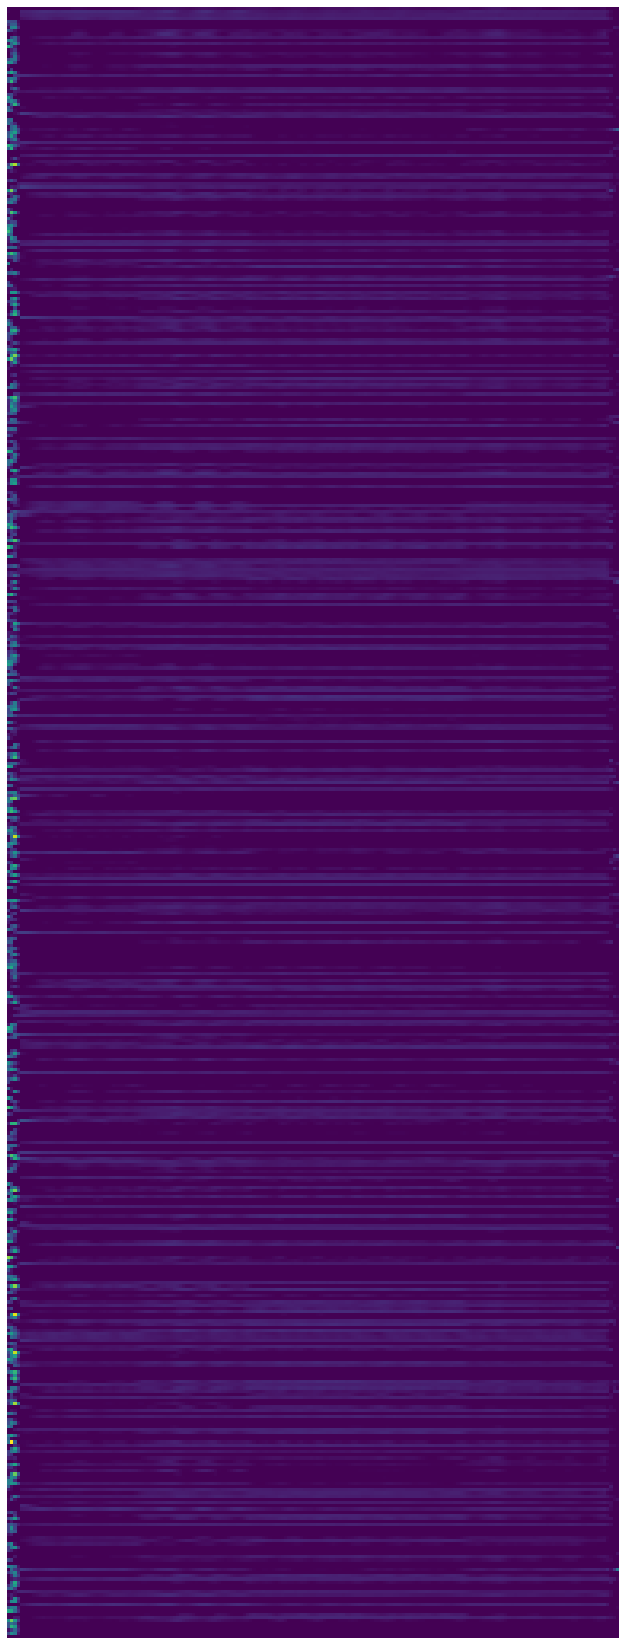

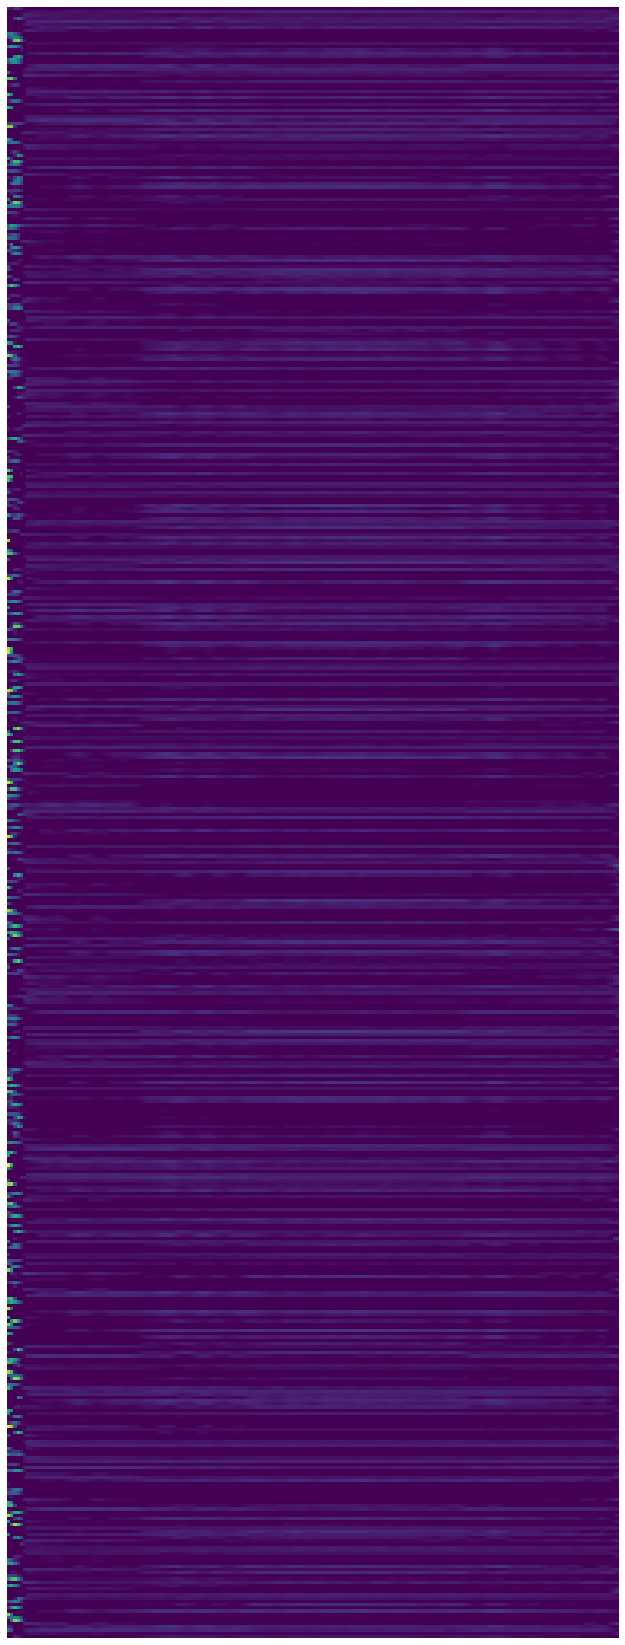

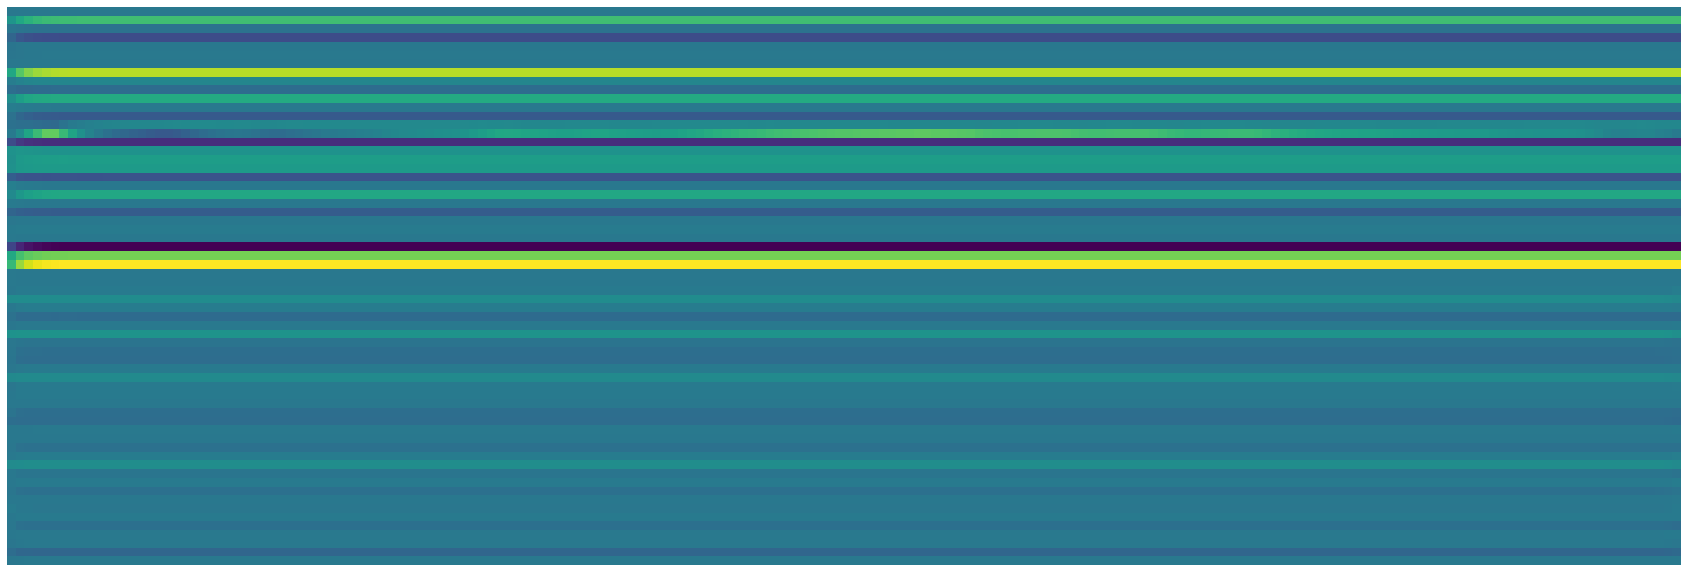

In [13]:
for batch_id in range(2):
    for layer in range(len(saved_enc_outs)):
        plt.figure(figsize=(30,30))
        example = saved_enc_outs[layer][batch_id]
        if len(example.shape) == 3:
            for i, tensor in enumerate(example):
                if i == 64:
                    break
                tensor_arr = tensor.cpu().detach().numpy()
                plt.subplot(8, 8, i + 1)
                plt.imshow(tensor_arr)
                plt.axis("off")
        else:
            tensor_arr = example.cpu().detach().numpy()
            plt.imshow(tensor_arr)
            plt.axis("off")
        print(f"Saving layer saved_enc_outs{layer} feature maps...")
        plt.savefig(autovc_model_dir + f"/tensor_views/SavedEncOuts_Batch{batch_id}_Layer{layer}_{enc_outs[layer]}.png")